# Визуализация работы натреннерованного агента на DQN + RB + SL

In [1]:
# импортируем
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import random
from collections import deque
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Чекаем CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Replya Buffer Реализация чз Torch
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)

        return (
            torch.FloatTensor(state).to(device),
            torch.LongTensor(action).to(device),
            torch.FloatTensor(reward).to(device),
            torch.FloatTensor(next_state).to(device),
            torch.FloatTensor(done).to(device),
        )

    def __len__(self):
        return len(self.buffer)

In [4]:
# DQN чз GPU
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim),
        ).to(device)

    def forward(self, x):
        return self.network(x)

    def act(self, state, epsilon):
        if random.random() < epsilon:
            return random.randint(0, self.network[-1].out_features - 1)

        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = self.forward(state)
            return torch.argmax(q_values).item()

In [5]:
# Агент
class DQNAgent:
    def __init__(
        self,
        state_dim,
        action_dim,
        lr=3e-4,
        gamma=0.99,
        buffer_size=100000,
        batch_size=256,
        target_update=0.005,
    ):
        self.action_dim = action_dim
        self.batch_size = batch_size
        self.gamma = gamma
        self.target_update = target_update

        # Основная и целевая сети
        self.q_network = DQN(state_dim, action_dim)
        self.target_network = DQN(state_dim, action_dim)
        self.target_network.load_state_dict(self.q_network.state_dict())

        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=lr)
        self.memory = ReplayBuffer(buffer_size)

    def update(self):
        if len(self.memory) < self.batch_size:
            return

        # Извлекаем batch из памяти
        state, action, reward, next_state, done = self.memory.sample(self.batch_size)

        # Вычисляем текущие Q-значения
        current_q = self.q_network(state).gather(1, action.unsqueeze(1))

        # Вычисляем целевые Q-значения
        with torch.no_grad():
            next_q = self.target_network(next_state).max(1)[0]
            target_q = reward + (1 - done) * self.gamma * next_q

        # Вычисляем loss и обновляем веса
        loss = nn.MSELoss()(current_q.squeeze(), target_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Мягкое обновление целевой сети
        for target_param, param in zip(
            self.target_network.parameters(), self.q_network.parameters()
        ):
            target_param.data.copy_(
                self.target_update * param.data
                + (1 - self.target_update) * target_param.data
            )

        return loss.item()

In [6]:
# функция треньки
def train(env_name, num_episodes, max_steps=1000):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    # Создаем агента
    agent = DQNAgent(state_dim, action_dim)

    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 0.995
    epsilon = epsilon_start

    episode_rewards = []
    losses = []

    for episode in tqdm(range(num_episodes)):
        state, _ = env.reset()
        episode_reward = 0
        episode_loss = 0
        steps = 0

        for step in range(max_steps):
            action = agent.q_network.act(state, epsilon)
            next_state, reward, done, truncated, _ = env.step(action)

            agent.memory.push(state, action, reward, next_state, float(done))
            state = next_state
            episode_reward += reward

            loss = agent.update()
            if loss is not None:
                episode_loss += loss

            steps += 1

            if done or truncated:
                break

        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        episode_rewards.append(episode_reward)
        losses.append(episode_loss / steps if steps > 0 else 0)

        if (episode + 1) % 20 == 0:
            avg_reward = np.mean(episode_rewards[-20:])
            print(
                f"\nEpisode {episode + 1}, Avg Reward: {avg_reward:.2f}, Epsilon: {epsilon:.2f}"
            )

    env.close()
    return episode_rewards, losses, agent  # Возвращаем агента

In [7]:
# делаем график
def plot_results(rewards, losses):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(rewards)
    plt.title("Episode Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")

    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Episode")
    plt.ylabel("Loss")

    plt.tight_layout()
    plt.show()

In [8]:
# Визуализация обученного агента
def visualize_agent(env_name, agent, num_episodes=5):
    env = gym.make(env_name, render_mode="human")

    for episode in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.q_network.act(
                state, epsilon=0
            )  # Используем только эксплуатацию
            next_state, reward, done, truncated, _ = env.step(action)
            total_reward += reward
            state = next_state

            if truncated:
                break

        print(f"Episode {episode + 1}: Total Reward = {total_reward:.2f}")

    env.close()

  0%|          | 0/500 [00:00<?, ?it/s]C:\Users\admin\AppData\Local\Temp\ipykernel_43532\3502048601.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  torch.FloatTensor(state).to(device),
  4%|▍         | 20/500 [00:06<02:58,  2.69it/s]


Episode 20, Avg Reward: -167.76, Epsilon: 0.90


  8%|▊         | 40/500 [00:13<02:58,  2.58it/s]


Episode 40, Avg Reward: -88.23, Epsilon: 0.82


 12%|█▏        | 60/500 [00:20<02:41,  2.72it/s]


Episode 60, Avg Reward: -102.64, Epsilon: 0.74


 16%|█▌        | 80/500 [00:27<02:28,  2.83it/s]


Episode 80, Avg Reward: -59.95, Epsilon: 0.67


 20%|██        | 100/500 [00:36<02:58,  2.24it/s]


Episode 100, Avg Reward: -55.89, Epsilon: 0.61


 24%|██▍       | 120/500 [00:46<02:56,  2.15it/s]


Episode 120, Avg Reward: -75.81, Epsilon: 0.55


 28%|██▊       | 140/500 [00:58<03:36,  1.67it/s]


Episode 140, Avg Reward: -99.06, Epsilon: 0.50


 32%|███▏      | 160/500 [01:09<03:11,  1.78it/s]


Episode 160, Avg Reward: -146.38, Epsilon: 0.45


 36%|███▌      | 180/500 [01:43<16:25,  3.08s/it]


Episode 180, Avg Reward: -90.75, Epsilon: 0.41


 40%|████      | 200/500 [02:35<11:26,  2.29s/it]


Episode 200, Avg Reward: -101.11, Epsilon: 0.37


 44%|████▍     | 220/500 [03:35<10:38,  2.28s/it]


Episode 220, Avg Reward: -15.80, Epsilon: 0.33


 48%|████▊     | 240/500 [04:34<14:19,  3.31s/it]


Episode 240, Avg Reward: 19.84, Epsilon: 0.30


 52%|█████▏    | 260/500 [05:45<13:27,  3.36s/it]


Episode 260, Avg Reward: 40.01, Epsilon: 0.27


 56%|█████▌    | 280/500 [06:48<08:52,  2.42s/it]


Episode 280, Avg Reward: 48.02, Epsilon: 0.25


 60%|██████    | 300/500 [07:47<11:16,  3.38s/it]


Episode 300, Avg Reward: 3.45, Epsilon: 0.22


 64%|██████▍   | 320/500 [08:51<10:22,  3.46s/it]


Episode 320, Avg Reward: 67.08, Epsilon: 0.20


 68%|██████▊   | 340/500 [10:00<09:31,  3.57s/it]


Episode 340, Avg Reward: 83.27, Epsilon: 0.18


 72%|███████▏  | 360/500 [11:00<06:07,  2.62s/it]


Episode 360, Avg Reward: 52.13, Epsilon: 0.16


 76%|███████▌  | 380/500 [12:04<05:21,  2.68s/it]


Episode 380, Avg Reward: 81.97, Epsilon: 0.15


 80%|████████  | 400/500 [13:09<06:03,  3.64s/it]


Episode 400, Avg Reward: 89.86, Epsilon: 0.13


 84%|████████▍ | 420/500 [14:24<04:16,  3.21s/it]


Episode 420, Avg Reward: 145.38, Epsilon: 0.12


 88%|████████▊ | 440/500 [15:40<04:06,  4.11s/it]


Episode 440, Avg Reward: 100.58, Epsilon: 0.11


 92%|█████████▏| 460/500 [16:54<02:42,  4.06s/it]


Episode 460, Avg Reward: 122.70, Epsilon: 0.10


 96%|█████████▌| 480/500 [17:58<01:20,  4.05s/it]


Episode 480, Avg Reward: 161.00, Epsilon: 0.09


100%|██████████| 500/500 [18:50<00:00,  2.26s/it]


Episode 500, Avg Reward: 154.09, Epsilon: 0.08


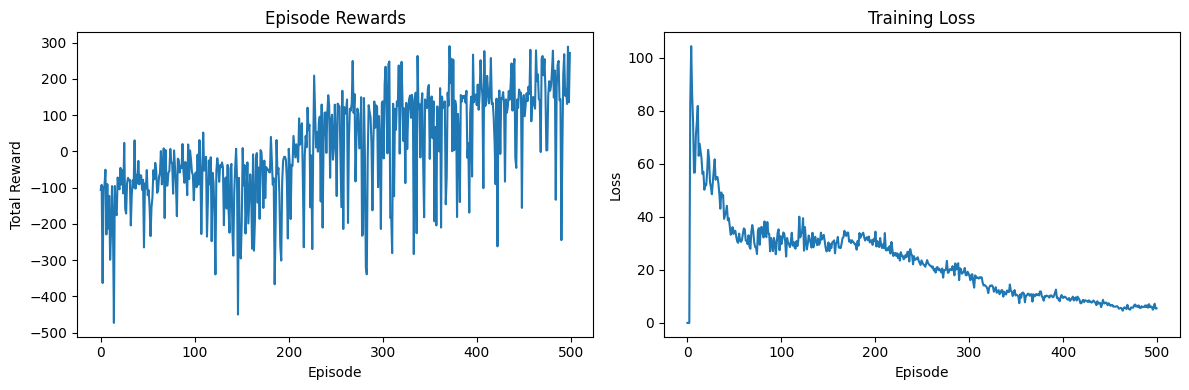


Starting visualization of trained agent...
Episode 1: Total Reward = 261.41
Episode 2: Total Reward = -33.71
Episode 3: Total Reward = 30.20
Episode 4: Total Reward = 259.33
Episode 5: Total Reward = 258.93

Starting visualization of trained agent...
Episode 1: Total Reward = 43.81
Episode 2: Total Reward = 2.46
Episode 3: Total Reward = 248.54
Episode 4: Total Reward = -35.51
Episode 5: Total Reward = 22.67


In [9]:
# Обучение агента
# Процесс
num_episodes = 500

# сохраняем Реварды лосы и агента
rewards, losses, agent = train("LunarLander-v3", num_episodes)  # Получаем агента

# риусем награды и лосы
plot_results(rewards, losses)

# Визуализация обученного агента
# окошко пайтона см. во вкладках если не открылось окошко
print("\nПокажи ка Агента Мне...")
visualize_agent("LunarLander-v3", agent, num_episodes=5)

# Опционально: сохранение модели
# для последуюещго тестирования обученности агента
torch.save(
    {
        "model_state_dict": agent.q_network.state_dict(),
        "optimizer_state_dict": agent.optimizer.state_dict(),
        "rewards": rewards,
        "losses": losses,
    },
    "lunar_lander_checkpoint.pth",
)

# Визуализация обученного агента
print("\nПокажи ка Агента Мне...")
visualize_agent("LunarLander-v3", agent)

In [10]:
# Если потом нужно загрузить модель: см. *.ptn
def load_agent(checkpoint_path, state_dim, action_dim):
    agent = DQNAgent(state_dim, action_dim)
    checkpoint = torch.load(checkpoint_path)
    agent.q_network.load_state_dict(checkpoint["model_state_dict"])
    agent.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    return agent, checkpoint["rewards"], checkpoint["losses"]

In [13]:
#посмотрим ещё на агента красавчика
visualize_agent("LunarLander-v3", agent)

Episode 1: Total Reward = 5.22
Episode 2: Total Reward = 264.69
Episode 3: Total Reward = 257.43
Episode 4: Total Reward = 267.28
Episode 5: Total Reward = 37.80
